In [1]:
import pandas as pd
import numpy as np
import os, re
import warnings
warnings.filterwarnings('ignore')
from dateutil.relativedelta import relativedelta

from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import missingno as msno
from collections import Counter
from datetime import datetime

from sklearn.metrics import mean_squared_error
%matplotlib inline

In [2]:
train_df = pd.read_csv(r"D:\29 CS5228\03 Project\HDBResalePrice\outs\train_df_fe_all.csv")

In [3]:
print(list(train_df.columns))

['month', 'town', 'flat_type', 'block', 'street_name', 'storey_range', 'floor_area_sqm', 'flat_model', 'eco_category', 'lease_commence_date', 'latitude', 'longitude', 'elevation', 'subzone', 'planning_area', 'region', 'resale_price', 'resale_year', 'resale_month', 'resale_quarter', 'flat_age', 'resale_price_sqm', 'commercial_CBD', 'commercial_type_CR', 'commercial_type_IEBP', 'commercial_type_IEPB', 'commercial_type_BN', 'commercial_type_IHL', 'hawker_ECLFV', 'hawker_NFC', 'hawker_CRB89', 'hawker_OARB51OARFCSM', 'hawker_CRB', 'hawker_HVMFC', 'hawker_BFC', 'hawker_CCFC', 'hawker_TBM', 'hawker_BPHC', 'hawker_GMFC', 'hawker_YPHC', 'hawker_OTH', 'hawker_KAHC', 'hawker__', 'hawker_highrating_', 'hawker_established_', 'prisch_top50_', 'prisch_top50_<=1km', 'prisch_top50_1to2km', 'prisch_top50_2to4km', 'malls_GWC', 'malls_IO', 'malls_TSMBS', 'malls_NAC', 'malls_PS', 'malls_SC', 'malls_OTH', 'malls_CA', 'malls_JCA', 'malls_VivoCity', 'malls_JP', 'malls__', 'malls_ratingsbin_4.1', 'malls_rating

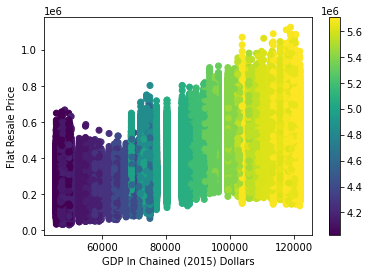

In [10]:
plt.scatter(train_df['quarterly_GICD'], train_df['resale_price'], c=train_df['annual_TP'])
plt.ylabel('Flat Resale Price')
plt.xlabel('GDP In Chained (2015) Dollars')
# plt.title('Scatter plot of HDB Resale Price by Singapore GDP (Colored by Annual Population)')
plt.colorbar()
plt.show()

In [20]:
dummy_list = []
bools = []
numerics = []
strings = []

def plot_lineplot(df, i, rotation=None, width=6, height=3.5, save=False, convert=False, i2=None):
    if convert:
        df[i] = df[i].applymap(lambda x: re.sub('[^0-9]', '', x))
    x = df[i].dropna()
    
    if i2 is None:
        i2 = 'count'
        nums = dict(Counter(x))
        nums_df = pd.DataFrame({
            i: list(nums.keys()),
            i2: list(nums.values())
        })
    else:
        nums_df = df.groupby([i])[i2].mean().reset_index()
    sns.set(rc={'figure.figsize':(width, height)})
    ax = sns.lineplot(data=nums_df, x=i, y=i2)
    ax.set_title(f'Lineplot of {i}')
    if rotation is not None:
        plt.xticks(rotation=rotation)
    plt.tight_layout()
    if save: plt.savefig(f'figs/eda_{i}_lineplot', bbox_inches = "tight")
    plt.show()
    
def plot_numeric(df, i, save=False):
    x = df[i]
    sns.set(rc={'figure.figsize':(6,1)})
    ax = sns.boxplot(x, color='lightblue')
    ax.set_title(f'Boxplot of {i}')
    plt.tight_layout()
    if save: plt.savefig(f'figs/eda_{i}_boxplot', bbox_inches = "tight")
    plt.show()
    
def plot_categorical(df, i, top_k=None, save=False):
    x = df[i]
    total = float(len(x))
    if top_k is None:
        n_cates = len(set(x))
    else:
        n_cates=top_k
    sns.set(rc={'figure.figsize':(6, n_cates/8+2)})
    sns.set(font="SimSun")
    ax = sns.countplot(y=x, color="lightblue", dodge=False, order = x.value_counts().iloc[:n_cates].index)
    for p in ax.patches:
        percentage = f'{100 * p.get_width() / total:.1f}%\n'
        x = p.get_width()
        y = p.get_y() + p.get_height() / 2
        ax.annotate(percentage, (x, y), ha='right', va='center')
    ax.set_title(f'Countplot of {i}')
    plt.tight_layout()
    if save: plt.savefig(f'figs/eda_{i}_countplot', bbox_inches = "tight")
    plt.show()
        
def plot_dates(df, i, save=False):
    x = df[i].dropna().apply(lambda d: datetime.strptime(d, dates_dict[i]))
    dates = dict(Counter(x))
    dates_df = pd.DataFrame({
        'date': list(dates.keys()),
        'count': list(dates.values())
    })
    sns.set(rc={'figure.figsize':(6,3.5)})
    ax = sns.lineplot(data=dates_df, x='date', y='count')
    ax.set_title(f'Lineplot of {i}')
    plt.tight_layout()
    if save: plt.savefig(f'figs/eda_{i}_lineplot', bbox_inches = "tight")
    plt.show()
    
def plot_all(df, top_k=None, save=False, num_string_pattern = '\d{4}\-\d{2}'):
    for i in df.columns:
        _df = df.dropna(subset=[i])
        if len(df)!=len(_df):
            print(f'Plot for "{i}" (Missing {len(df)-len(_df)} items...)')
        else:
            print(f'Plot for "{i}"')
        if is_numeric_dtype(df[i]):
            if len(set(_df))==2:
                bools.append(i, save=save)
                plot_categorical(_df, i, top_k=top_k, save=save)
            else:
                numerics.append(i)
                plot_numeric(_df, i, save=save)
                if i in dummy_list:
                    plot_categorical(_df, i, top_k=top_k, save=save)
        else:
            if i in dates_dict.keys():
                plot_dates(_df, i, save=save)
            elif all([bool(re.match(num_string_pattern, s)) for s in _df[i]]):
                # this matches Year-Month format of YYYY-MM (can custom pattern, or by |)
                plot_lineplot(_df, i, rotation=90, height=3.5, width=len(df[i].unique())/7.2, save=save)
            else:
                strings.append(i)
                plot_categorical(_df, i, save=save)
    
    print(f'----- auto eda summary -----')
    print(f'identified bools: {bools}')
    print(f'identified numerics: {numerics}')
    print(f'identified strings: {strings}')
    print(f'cols to fix: {list(train_df.columns.difference(bools+numerics+strings))}')


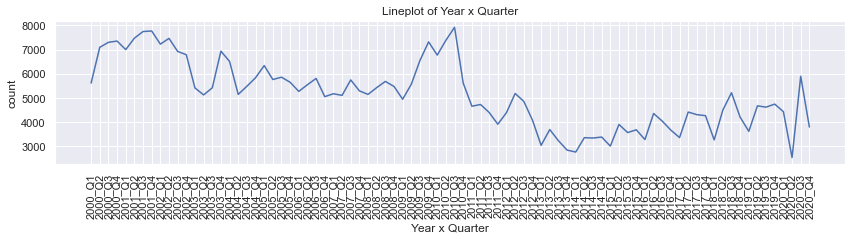

In [19]:
train_df['Year x Quarter'] = [str(y)+'_Q'+str(q) for y,q in zip(train_df['resale_year'], train_df['resale_quarter'])]
plot_lineplot(train_df, 'Year x Quarter', rotation=90, width=12)

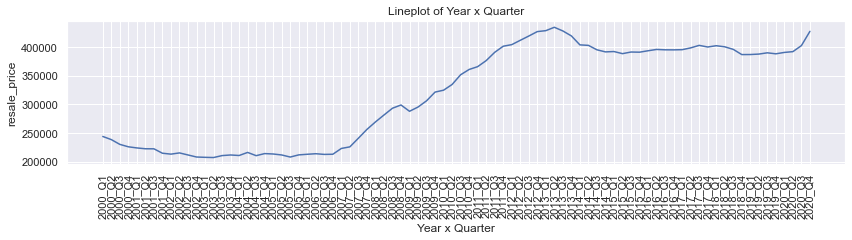

In [21]:
plot_lineplot(train_df, 'Year x Quarter', i2='resale_price', rotation=90, width=12)

In [8]:
def custom_binscatter(x, y, nbins = 10, xlabel='actual', ylabel='predicted', 
                      title='Plot of Predicted vs Actual in KFold Train'):
    """
    Adapted code from https://stackoverflow.com/questions/15556930/turn-scatter-data-into-binned-data-with-errors-bars-equal-to-standard-deviation
    """
    n, _ = np.histogram(x, bins=nbins)
    sy, _ = np.histogram(x, bins=nbins, weights=y)
    sy2, _ = np.histogram(x, bins=nbins, weights=y*y)
    mean = sy / n
    std = np.sqrt(sy2/n - mean*mean)

    plt.plot(x, y, 'bo')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.errorbar((_[1:] + _[:-1])/2, mean, yerr=std, fmt='r-')
    plt.show()


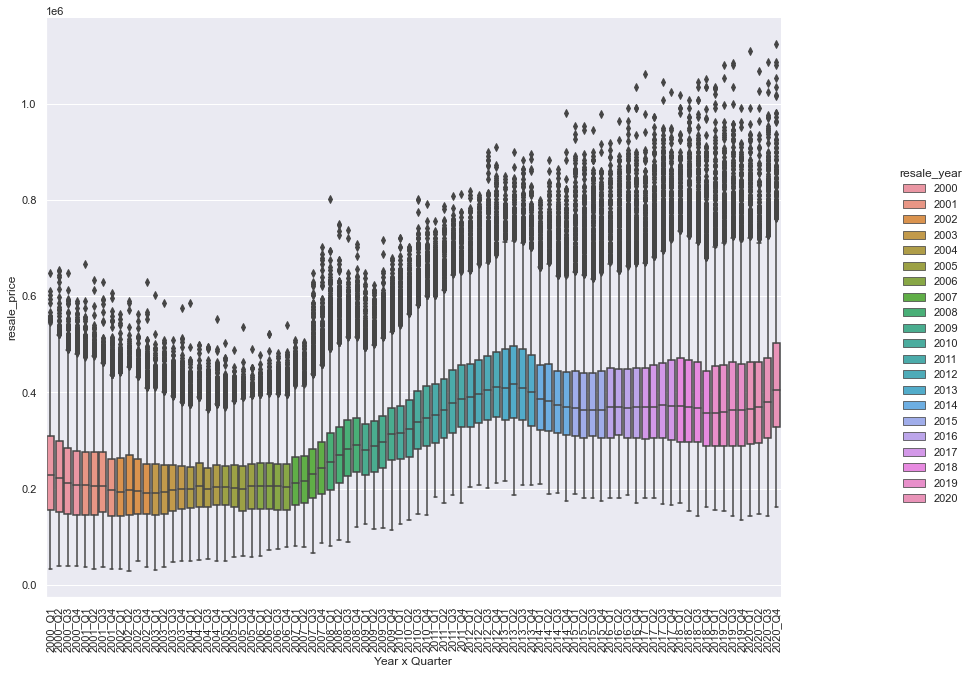

In [35]:
plot_data = train_df.sort_values(by='Year x Quarter').copy()
g = sns.catplot(x='Year x Quarter', y="resale_price", hue='resale_year', kind="box", dodge=False, data=plot_data)
g.set_xticklabels(rotation=90)
g.fig.set_size_inches(15,10)

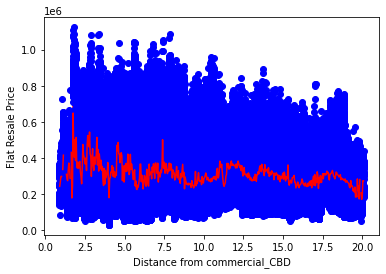

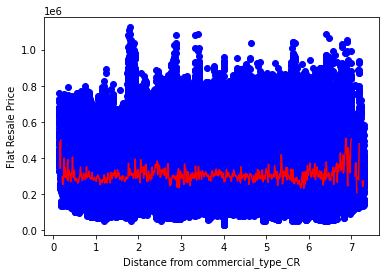

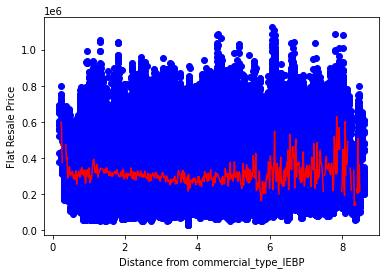

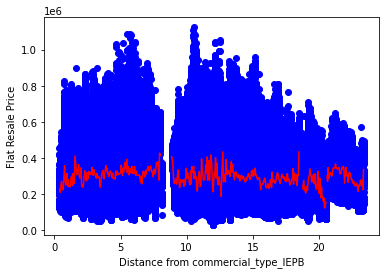

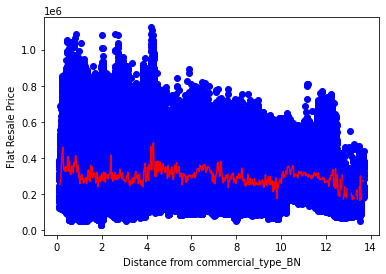

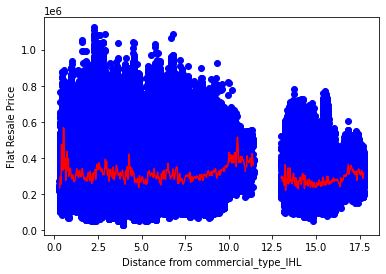

In [16]:
study_cols = [
    'commercial_CBD',
    'commercial_type_CR',
    'commercial_type_IEBP',
    'commercial_type_IEPB',
    'commercial_type_BN',
    'commercial_type_IHL']

for i in study_cols:
    custom_binscatter(train_df[i], train_df['resale_price'], nbins = 500, 
                      xlabel=f'Distance from {i}', ylabel='Flat Resale Price', title='')

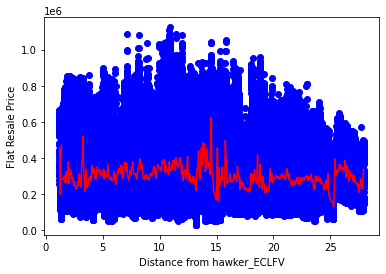

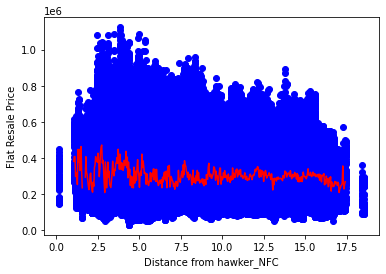

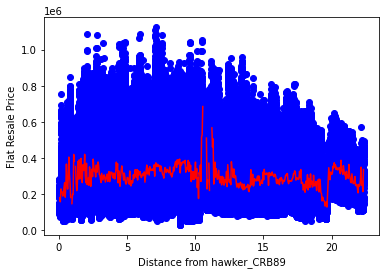

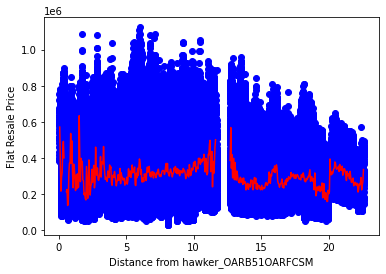

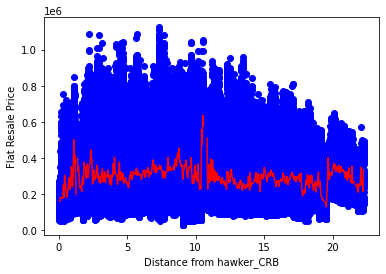

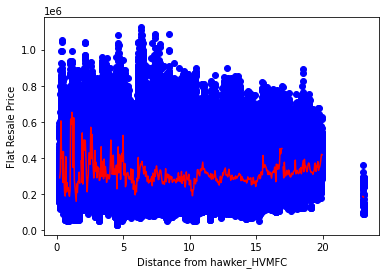

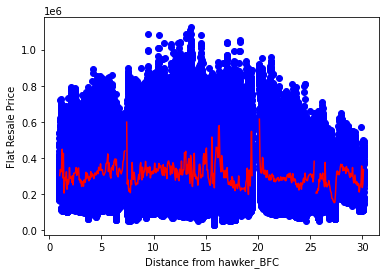

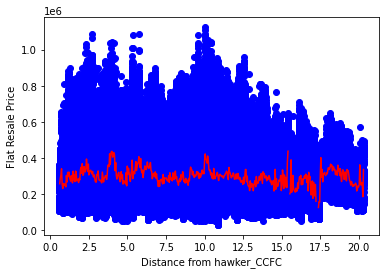

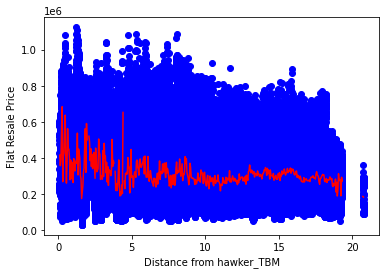

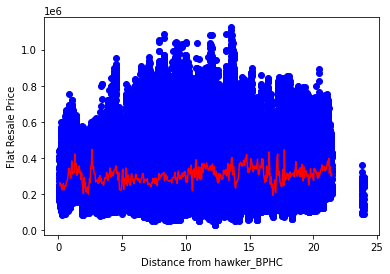

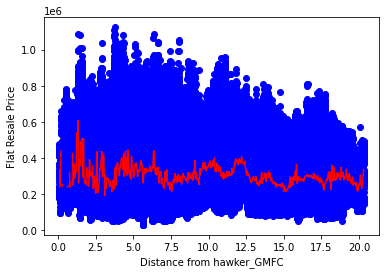

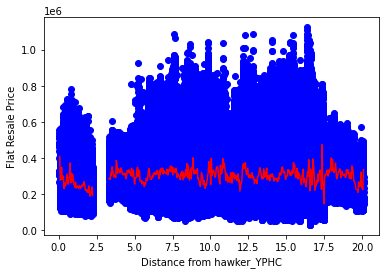

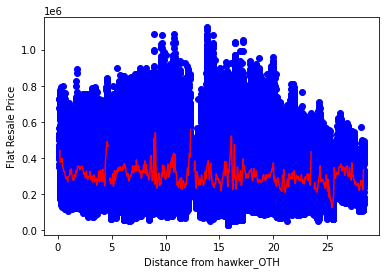

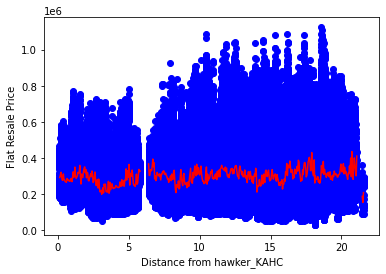

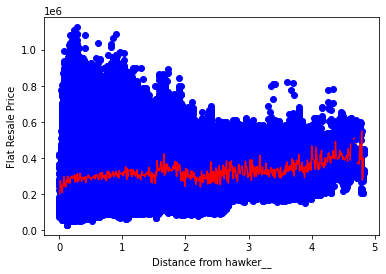

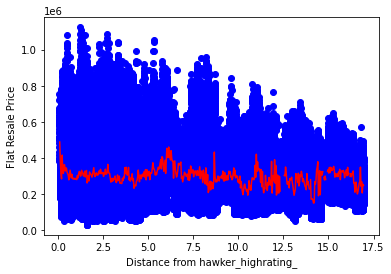

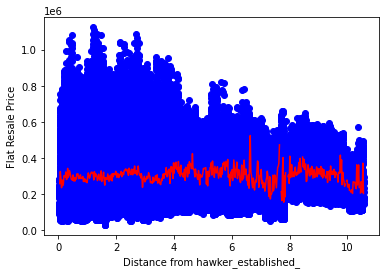

In [17]:
study_cols = [i for i in train_df.columns if 'hawker_' in i]

for i in study_cols:
    custom_binscatter(train_df[i], train_df['resale_price'], nbins = 500, 
                      xlabel=f'Distance from {i}', ylabel='Flat Resale Price', title='')

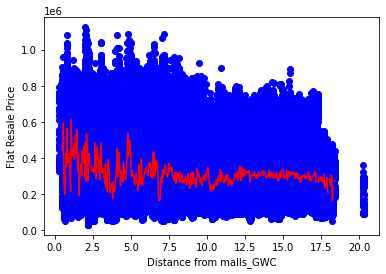

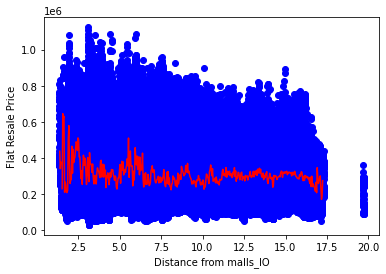

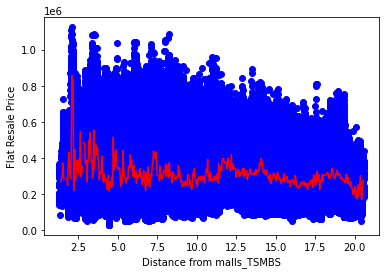

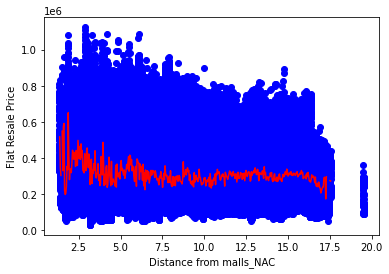

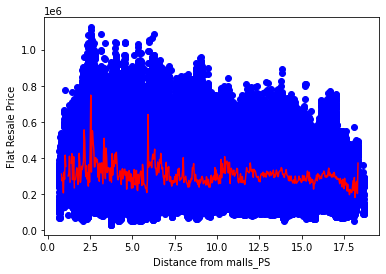

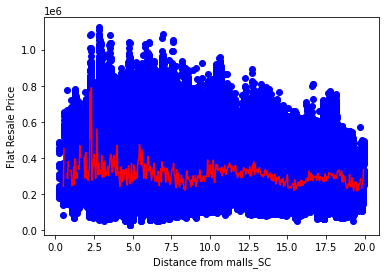

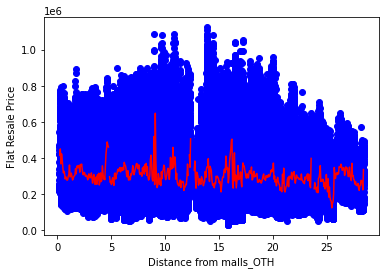

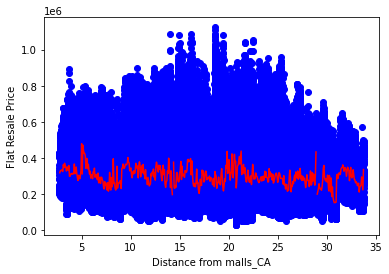

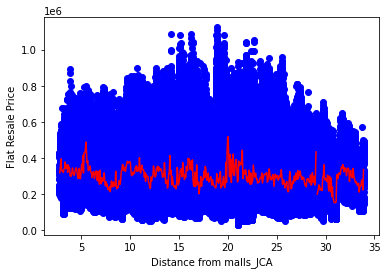

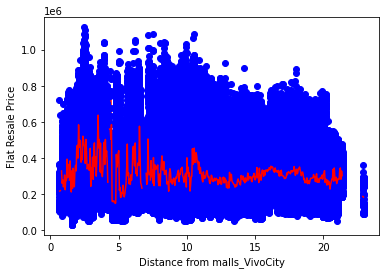

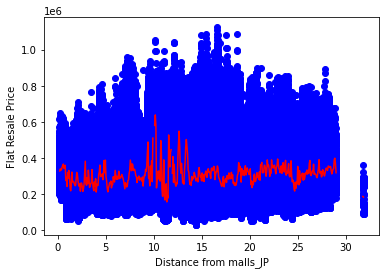

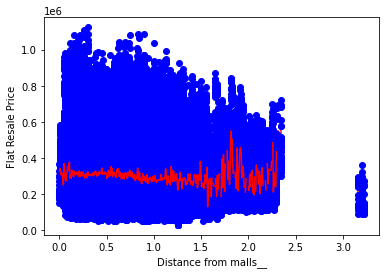

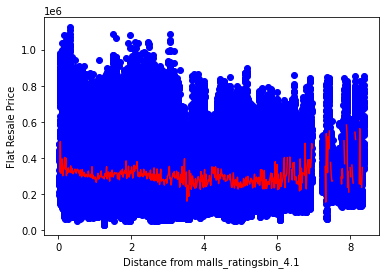

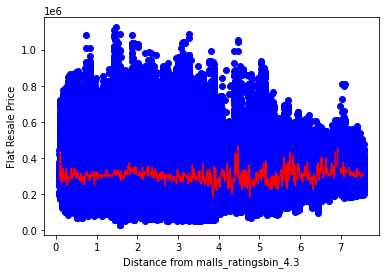

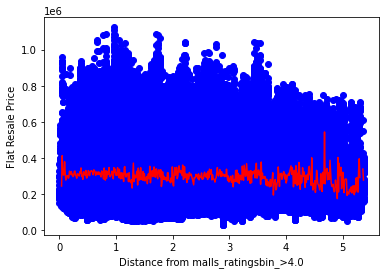

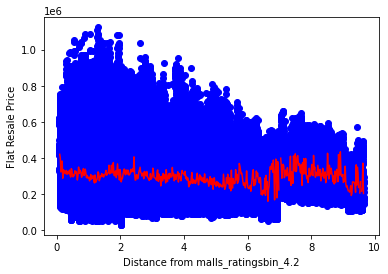

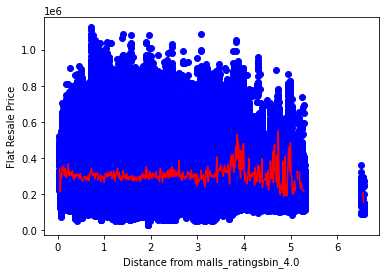

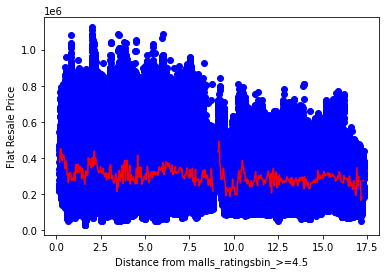

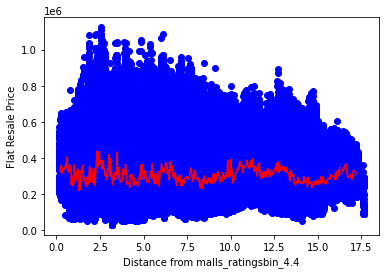

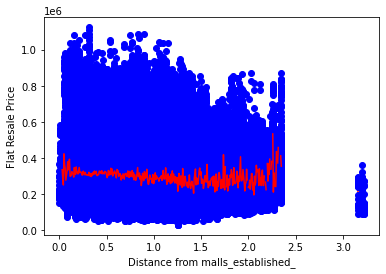

In [21]:
study_cols = [i for i in train_df.columns if 'malls_' in i]

for i in study_cols:
    custom_binscatter(train_df[i], train_df['resale_price'], nbins = 500, 
                      xlabel=f'Distance from {i}', ylabel='Flat Resale Price', title='')

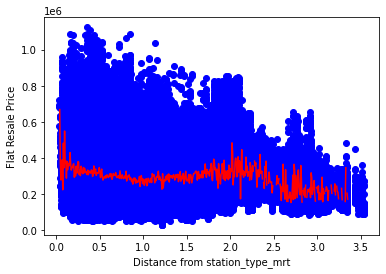

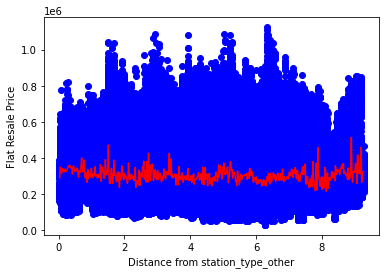

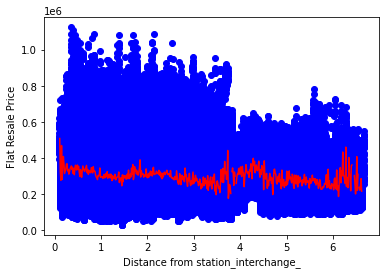

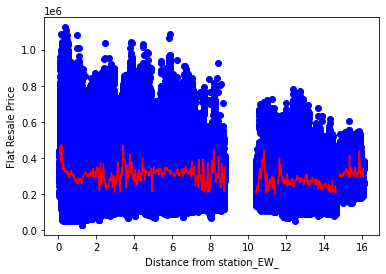

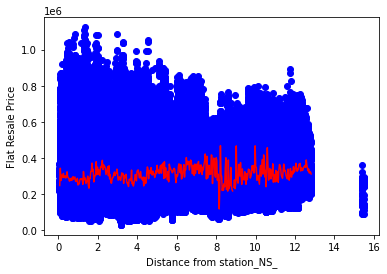

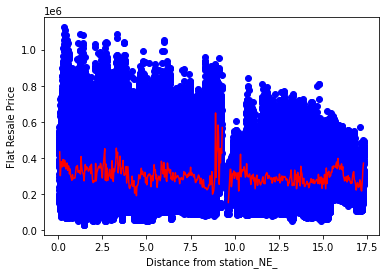

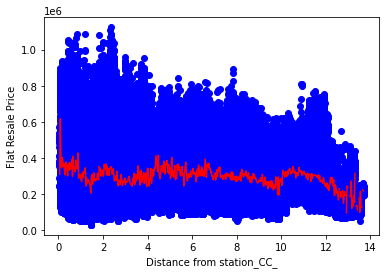

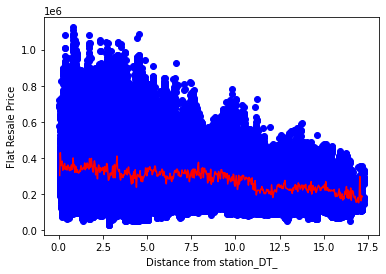

In [23]:
study_cols = [i for i in train_df.columns if 'station_' in i]

for i in study_cols:
    custom_binscatter(train_df[i], train_df['resale_price'], nbins = 500, 
                      xlabel=f'Distance from {i}', ylabel='Flat Resale Price', title='')

### example map

In [51]:
train_df[train_df['commercial_CBD'] == min(train_df['commercial_CBD'])].index

Int64Index([  7169,  15055,  33680,  34218,  38784,  39581,  45225,  47646,
             48204,  49090,  49531,  72458,  74700,  80781,  85222,  86798,
             88042,  90320,  95426, 102737, 132663, 142778, 154373, 171842,
            182796, 192443, 195021, 207657, 212984, 230583, 239406, 240392,
            271400, 274354, 280558, 289813, 294368, 296122, 303265, 309393,
            311756, 313508, 323651, 327342, 329384, 351916, 353829, 359499,
            362583, 391967, 401909, 405941, 407586, 413835, 416191, 424835,
            426748, 427380],
           dtype='int64')

In [52]:
train_df.loc[7169]

month                              2006-10
town                       kallang/whampoa
flat_type                           3 room
block                                    0
street_name                     Beach Road
                                ...       
HDB_Completed                          NaN
HDB_Under Construction                 NaN
DBSS_Completed                         NaN
DBSS_Under Construction                NaN
Year x Quarter                     2006_Q4
Name: 7169, Length: 106, dtype: object

In [53]:
print(train_df.loc[7169]['latitude'], train_df.loc[7169]['longitude'])
print(train_df.loc[7169][[i for i in train_df.columns if 'hawker' in i]])

1.29480140149802 103.854467487996
hawker_ECLFV             8.9907
hawker_NFC               2.5373
hawker_CRB89             4.7117
hawker_OARB51OARFCSM     3.7961
hawker_CRB               4.9151
hawker_HVMFC             6.8607
hawker_BFC              11.5825
hawker_CCFC              7.8355
hawker_TBM               2.6961
hawker_BPHC             13.0117
hawker_GMFC              1.3783
hawker_YPHC             14.5058
hawker_OTH              11.5217
hawker_KAHC             17.2273
hawker__                 0.7035
hawker_highrating_       1.3783
hawker_established_      1.3783
Name: 7169, dtype: object


In [54]:
print(train_df.loc[7169]['latitude'], train_df.loc[5679]['longitude'])
print(train_df.loc[7169][[i for i in train_df.columns if 'station' in i]])

1.29480140149802 103.93186323479
station_type_mrt        0.2009
station_type_other      5.0718
station_interchange_    0.2946
station_EW_             0.2946
station_NS_             0.2946
station_NE_             1.0601
station_CC_             0.2009
station_DT_             0.6132
Name: 7169, dtype: object


In [55]:
print(train_df.loc[7169]['latitude'], train_df.loc[5679]['longitude'])
print(train_df.loc[7169][[i for i in train_df.columns if 'malls' in i]])

1.29480140149802 103.93186323479
malls_GWC                  2.5029
malls_IO                   2.7065
malls_TSMBS                1.2922
malls_NAC                  2.3808
malls_PS                   1.2344
malls_SC                   0.5024
malls_OTH                 11.5653
malls_CA                  16.4499
malls_JCA                 16.6983
malls_VivoCity             4.8706
malls_JP                  17.3159
malls__                    0.0814
malls_ratingsbin_4.1       1.9864
malls_ratingsbin_4.3       0.2902
malls_ratingsbin_>4.0      0.4048
malls_ratingsbin_4.2       0.6307
malls_ratingsbin_4.0       1.7773
malls_ratingsbin_>=4.5     1.2922
malls_ratingsbin_4.4       0.5024
malls_established_         0.2902
Name: 7169, dtype: object


In [56]:
print(train_df.loc[7169]['latitude'], train_df.loc[5679]['longitude'])
print(train_df.loc[7169][[i for i in train_df.columns if 'commercial' in i]])

1.29480140149802 103.93186323479
commercial_CBD          0.8933
commercial_type_CR      0.8933
commercial_type_IEBP    7.2983
commercial_type_IEPB    8.1159
commercial_type_BN       3.062
commercial_type_IHL     0.4823
Name: 7169, dtype: object


In [58]:
print(train_df.loc[7169]['latitude'], train_df.loc[5679]['longitude'])
print(train_df.loc[7169][[i for i in train_df.columns if 'prisch' in i]])

1.29480140149802 103.93186323479
prisch_top50_          2.0456
prisch_top50_<=1km          0
prisch_top50_1to2km         0
prisch_top50_2to4km         1
Name: 7169, dtype: object


In [59]:
_temp = pd.read_csv(r"D:\29 CS5228\03 Project\HDBResalePrice\outs\train_df_fe_prisch.csv")
_temp.loc[7169]

prisch_APS             17.5368
prisch_AIPS            15.6494
prisch_ATS              7.7071
prisch_APSV3            3.4022
prisch_AGPS            11.2390
                        ...   
prisch_ZPSV190          7.4356
prisch_top50_           2.0456
prisch_top50_<=1km      0.0000
prisch_top50_1to2km     0.0000
prisch_top50_2to4km     1.0000
Name: 7169, Length: 195, dtype: float64

In [61]:
_temp.loc[7169][_temp.loc[7169]==2.0456]

prisch_RVPS      2.0456
prisch_top50_    2.0456
Name: 7169, dtype: float64

https://tinyurl.com/yk2qd7x8

print(train_df.loc[7169]['latitude'], train_df.loc[7169]['longitude'])
1.29480140149802, 103.854467487996

hawker_GMFC              1.3783
Golden Mile Food Centre	
1.302874, 103.863876

station_CC_             0.2009
Esplanade	CC3	
1.293320941, 103.8555038

station_interchange_    0.2946
station_EW_             0.2946
City Hall	EW13/NS25	
1.292935576, 103.8525856

malls_SC                   0.5024
Suntec City	
1.296062, 103.8588075

commercial_CBD          0.8933
Central Business District	CR	
1.286768414, 103.8545286

prisch_RVPS      2.0456
prisch_top50_    2.0456
"River Valley Primary School": "prisch_RVPS",
River Valley Primary School	
1.29398185, 103.8360847

In [62]:
train_df.loc[7169]['resale_price']

191700.0